# Анализ поведение пользователей в приложении по средством анализа воронки продаж и A/A/B-эксперимента

# Цели и задачи проекта

> Главной целью проекта является анализ ***поведение пользователей в нашем мобильном приложении*** для доставки еды, посредством изучение анализа данных составление воронки продаж, исследования пути пользователей до покупки и подсчёт пользователей совершивших её и «застрявших на определённых шагах», определить на каких.

> После этого нам необходимо будет ***исследовать результаты A/A/B-эксперимента.*** Необходимо будет исследовать влияние изменение шрифтов на пользоватей. Пользователи разбиты на 3 группы: 2 контрольные со старыми шрифтами и одну экспериментальную — с новыми. Необходимо выяснить, какой шрифт лучше.

# Описание данных

Каждая запись в логе — это действие пользователя, или событие.
- EventName — название события;
- DeviceIDHash — уникальный идентификатор пользователя;
- EventTimestamp — время события;
- ExpId — номер эксперимента: 246 и 247 — контрольные группы, а 248 — экспериментальная.

# Краткий план работ

- Шаг 1. Импорт библиотек,  загрузка файла с данными и изучение общей информации
- Шаг 2. Преобработка данных
- Шаг 3. Проверка данных
- Шаг 4. Исследования воронки событий
- Шаг 5. Изучение результатов эксперимента

## Импорт библиотек,  загрузка файла с данными и изучение общей информации

In [28]:
import pandas as pd
import datetime as dt
import numpy as np
import matplotlib.pyplot as plt
from plotly import graph_objects as go
from scipy import stats
from statsmodels.stats.proportion import proportions_ztest
import math

In [29]:
data = pd.read_csv('/datasets/logs_exp.csv', sep='\t')
# выводим первые 5 строк датасета
display(data.head())
# вывод общей информации датасета
print(data.info())
# смотрим количество пропущенных значений
print('Количество пропусков в столбцах', data.isna().sum(),sep = '\n')
#посмотрим явные дубликаты в датасете
print('Количество дубликатов', data.duplicated().sum())
print('Процент дубликатов',  "{0:.2%}".format(data.duplicated().sum()/len(data)))

,EventName,DeviceIDHash,EventTimestamp,ExpId
0,MainScreenAppear,4575588528974610257,1564029816,246
1,MainScreenAppear,7416695313311560658,1564053102,246
2,PaymentScreenSuccessful,3518123091307005509,1564054127,248
3,CartScreenAppear,3518123091307005509,1564054127,248
4,PaymentScreenSuccessful,6217807653094995999,1564055322,248


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 244126 entries, 0 to 244125
Data columns (total 4 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   EventName       244126 non-null  object
 1   DeviceIDHash    244126 non-null  int64 
 2   EventTimestamp  244126 non-null  int64 
 3   ExpId           244126 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 7.5+ MB
None
Количество пропусков в столбцах
EventName         0
DeviceIDHash      0
EventTimestamp    0
ExpId             0
dtype: int64
Количество дубликатов 413
Процент дубликатов 0.17%


## Преобработка данных

In [30]:
# перевод названий столбцов в в удобный вид
data.rename(columns = {'EventName' : 'event_name', 'DeviceIDHash':'user_id','EventTimestamp':'timestamp','ExpId':'exp_id'}, inplace = True)
print(data.columns)
# удаление дубликатов
data = data.drop_duplicates()
print(data.duplicated().sum())
# обработка столбца с датой и временем события 
data['timestamp'] = pd.to_datetime(data['timestamp'], unit='s')
# создание cтолбца с датой
data['date'] = pd.to_datetime(data["timestamp"], unit="s")
display(data.head())
display(data.info())

Index(['event_name', 'user_id', 'timestamp', 'exp_id'], dtype='object')
0


,event_name,user_id,timestamp,exp_id,date
0,MainScreenAppear,4575588528974610257,2019-07-25 04:43:36,246,2019-07-25 04:43:36
1,MainScreenAppear,7416695313311560658,2019-07-25 11:11:42,246,2019-07-25 11:11:42
2,PaymentScreenSuccessful,3518123091307005509,2019-07-25 11:28:47,248,2019-07-25 11:28:47
3,CartScreenAppear,3518123091307005509,2019-07-25 11:28:47,248,2019-07-25 11:28:47
4,PaymentScreenSuccessful,6217807653094995999,2019-07-25 11:48:42,248,2019-07-25 11:48:42


<class 'pandas.core.frame.DataFrame'>
Int64Index: 243713 entries, 0 to 244125
Data columns (total 5 columns):
 #   Column      Non-Null Count   Dtype         
---  ------      --------------   -----         
 0   event_name  243713 non-null  object        
 1   user_id     243713 non-null  int64         
 2   timestamp   243713 non-null  datetime64[ns]
 3   exp_id      243713 non-null  int64         
 4   date        243713 non-null  datetime64[ns]
dtypes: datetime64[ns](2), int64(2), object(1)
memory usage: 11.2+ MB


None

## Проверка данных

### Расчёт количества пользователей,событий и максимальной и минимальной даты

In [31]:
# расчёт количества событий в логе 
print('Всего','событий', len(data['timestamp']))
# расчёт общего количества пользователей
print('Всего','пользователей', data['user_id'].nunique())
# сколько в среднем событий приходится на пользователя
print('''Среднее количество событий на пользователя''', data.groupby('user_id').agg({'timestamp':'count'}).mean()[0].round())
# максимальная и минимальная дата события
print('''Максимальной датой событий является''', data['date'].max())
print('''Минимальной датой событий является''', data['date'].min())

Всего событий 243713
Всего пользователей 7551
Среднее количество событий на пользователя 32.0
Максимальной датой событий является 2019-08-07 21:15:17
Минимальной датой событий является 2019-07-25 04:43:36


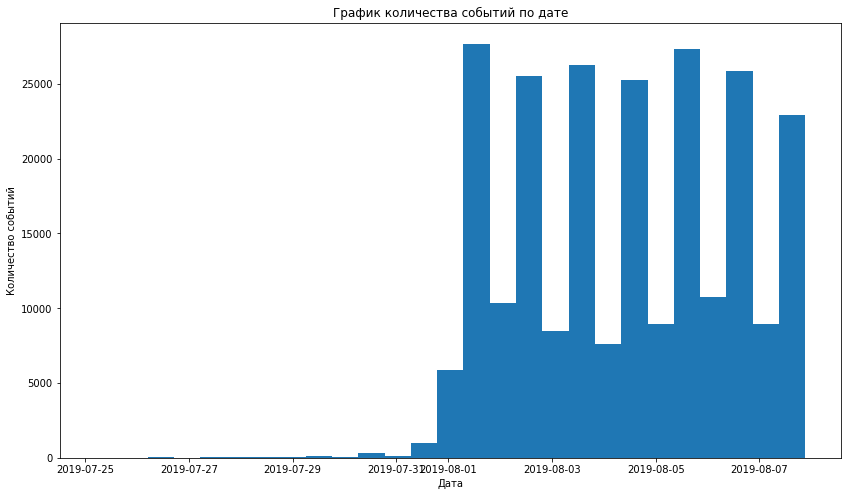

In [32]:
# Гистограмма по дате
plt.figure(figsize=(14,8))
plt.xlabel("Дата")
plt.ylabel("Количество событий")
plt.title("График количества событий по дате")
plt.hist(data['timestamp'],bins=27)
plt.show()

In [33]:
start_date =  pd.to_datetime('2019-08-1')

print('''Количество событий приходится на июль:''', len(data[data['date'] < start_date]))

print('''Процент событий приходится на июль:''', "{0:.2%}".format(len(data[data['date'] < start_date])/len(data)))

print('''Количество пользователей совершивших событие в  июле:''', data[data['date'] < start_date]['user_id'].nunique())

print('''Процент пользователей совершивших событие в  июле:''', "{0:.2%}".format((data[data['date'] < start_date]['user_id'].nunique()/data['user_id'].nunique())))

Количество событий приходится на июль: 2826
Процент событий приходится на июль: 1.16%
Количество пользователей совершивших событие в  июле: 1451
Процент пользователей совершивших событие в  июле: 19.22%


In [34]:
# удаление "июльских" событий    
total_user = data['user_id'].nunique()
total_event = data['date'].count()
data = data.query('date >= @start_date')
print('''Количество удалённых пользователей:''', total_user - data['user_id'].nunique())
print('''Процент удалённых пользователей:''',"{0:.2%}".format(-((data['user_id'].nunique())/total_user - 1)))
print('''Процент оставшихся событий:''',"{0:.2%}".format(data['date'].count()/total_event))

Количество удалённых пользователей: 17
Процент удалённых пользователей: 0.23%
Процент оставшихся событий: 98.84%


In [35]:
print('''Максимальной датой событий является''', data['date'].max())
print('''Минимальной датой событий является''', data['date'].min())

Максимальной датой событий является 2019-08-07 21:15:17
Минимальной датой событий является 2019-08-01 00:07:28


Как видно из расчётов выше 99,84% данных событий приходятся на август и лишь 1.16%(2826) событий на июль 19.22% (1451) пользователей выполнили события в июле, события относительно основных данных вместе с августом  немного, при этом только 17 пользователей совершивших события только в июле, их было решено удалить, так как по сути мы располагаем данными с 1 августа 2019г. 

### Проверка на пользователей состоящих в более одной группе 

In [36]:
same_users = (data.groupby('user_id',as_index=False)
                   .agg({'exp_id':'nunique'})
                   .sort_values(by='exp_id', ascending=False)
             )
same_users = same_users.query('exp_id > 1')
print(same_users)


Empty DataFrame
Columns: [user_id, exp_id]
Index: []


При фильтрации получен пустой датафрейм, отдельных пользователей состоящих в разных группах нет

## Исследования воронки событий

### Частота событий

In [37]:
# Подсчёт частоты событий
count_events = (data.groupby('event_name',as_index=False)
                   .agg({'timestamp':'count'})
                   .sort_values(by='timestamp',ascending=False)
                   .rename(columns = {'timestamp':'count_events'})
              )               
display(count_events)

,event_name,count_events
1,MainScreenAppear,117328
2,OffersScreenAppear,46333
0,CartScreenAppear,42303
3,PaymentScreenSuccessful,33918
4,Tutorial,1005


### Количество пользователей совершивших определённое событие и последовательность событий 

In [38]:
# Подсчёт количества пользователей
count_users = (data.groupby('event_name', as_index=False)
                   .agg({'user_id':'nunique'})
                   .sort_values(by='user_id',ascending=False)
                   .rename(columns = {'user_id':'count_users'})
              )
print(data['user_id'].nunique())
count_users['share_users'] = round(count_users['count_users']/data['user_id'].nunique(), 2)
display(count_users)


7534


,event_name,count_users,share_users
1,MainScreenAppear,7419,0.98
2,OffersScreenAppear,4593,0.61
0,CartScreenAppear,3734,0.50
3,PaymentScreenSuccessful,3539,0.47
4,Tutorial,840,0.11


## По убыванию количества пользователей от самого популярного события и события по очередности для воронки продаж делятся на:
- Выход на главный экран выполнило 7419 пользователя это самое популярное событие  по очередности это ***1 событие***
- Выход на страницу предложений выполнило 4606 пользователей это  по очередности ***2 событие***
- Выход на страницу «корзины» выполнило 3742 пользователей это по очередности  ***3 событие***
- Выход на страницу подтверждающую успешную оплату выполнило 3542 пользователей это по очередности  ***4 событие***
- Страницу просмотра руководства пользования сайтом выполнило 845 пользователей они к воронке продаж не относятся и посредовательность ***не может быть определена и её необходимо исключить***, можно только предположить что вероятно данное событие чащё происходило впервую очередь

In [39]:
sales_funnel = count_users.query('event_name != "Tutorial"')

display(sales_funnel)

,event_name,count_users,share_users
1,MainScreenAppear,7419,0.98
2,OffersScreenAppear,4593,0.61
0,CartScreenAppear,3734,0.50
3,PaymentScreenSuccessful,3539,0.47


### Подсчёт количества пользователей прошедших от первого события до платы, прошедших определённый этап и потерянных на этом этапе, виузалиция воронки событий

In [41]:
fig = go.Figure(go.Funnel(
    y = sales_funnel['event_name'],
    x = sales_funnel['count_users'],
    textinfo = "value+percent previous+percent initial")
               )
fig.update_layout(title="Воронка событий")
fig.show()

In [14]:
# создание столбца с долями пользователей от предыдущего события
sales_funnel['previous_share'] = round(sales_funnel['count_users']/sales_funnel['count_users'].shift(1, fill_value=7429),2)
# создание столбца с долями пользователей от первого события
sales_funnel['initial_share'] = round(sales_funnel['count_users']/sales_funnel['count_users'][1],2)
display(sales_funnel)


/tmp/ipykernel_48/1336379176.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/tmp/ipykernel_48/1336379176.py:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,event_name,count_users,share_users,previous_share,initial_share
1,MainScreenAppear,7419,0.98,1.00,1.00
2,OffersScreenAppear,4593,0.61,0.62,0.62
0,CartScreenAppear,3734,0.50,0.81,0.50
3,PaymentScreenSuccessful,3539,0.47,0.95,0.48


Как видно из графика воронки лишь большая часть пользователей «отваливается» на втором шаге OffersScreenAppear(Выход на страницу предложений) а именно 2826 пользователей или 38% от шага 1, доля пользователей доходящие от шага 1 до последнего шага оплаты состовляет 48%, в конверсия в целом очень хорошая

## Изучение результатов эксперимента

### Количество пользователей в группах

In [15]:
# Подсчёт в группах количества пользователей
count_exp_user = (data.query('event_name != "Tutorial"')
                      .groupby('exp_id',as_index=False)['user_id']
                      .nunique()
                      .rename(columns = {'user_id':'count_users'})
                 )
# Добавление сумму 246 и 247 груп
count_exp_user.loc[len(count_exp_user.index)] = ['246_247', count_exp_user['count_users'][0] + count_exp_user['count_users'][1]]
display(count_exp_user)

,exp_id,count_users
0,246,2483
1,247,2512
2,248,2535
3,246_247,4995


Группы приблизительно равны по численности

### Проверка на разницу статистических критериев между выборками 246 и 247(Проверка АА-теста)

In [16]:
# Подсчёт количества пользователей группы 246
user_246 = (data.query('exp_id == 246 & event_name != "Tutorial"')
                   .groupby('event_name', as_index=False)
                   .agg({'user_id':'nunique'})
                   .sort_values(by='user_id',ascending=False)
                   .rename(columns = {'user_id':'246'})
              )
# Подсчёт количества пользователей группы 247
user_247 = (data.query('exp_id == 247 & event_name != "Tutorial"')
                   .groupby('event_name', as_index=False)
                   .agg({'user_id':'nunique'})
                   .sort_values(by='user_id',ascending=False)
                   .rename(columns = {'user_id':'247'})
              )
# Подсчёт количества пользователей группы 248
user_248 = (data.query('exp_id == 248 & event_name != "Tutorial"')
                   .groupby('event_name', as_index=False)
                   .agg({'user_id':'nunique'})
                   .sort_values(by='user_id',ascending=False)
                   .rename(columns = {'user_id':'248'})
              )
users_events_per_group = user_246.merge(user_247, on='event_name').merge(user_248, on='event_name')
users_events_per_group['246_247'] = users_events_per_group['246'] + users_events_per_group['247']

print(users_events_per_group)

                event_name   246   247   248  246_247
0         MainScreenAppear  2450  2476  2493     4926
1       OffersScreenAppear  1542  1520  1531     3062
2         CartScreenAppear  1266  1238  1230     2504
3  PaymentScreenSuccessful  1200  1158  1181     2358


Самое популярное событие MainScreenAppear(Выход на главный экран)

In [17]:
# расчёт долей выполнивших самое популярное событие в группах
print('''Событие MainScreenAppear в группе 246 выполнило ''', '{:.2%}'.format(users_events_per_group['246'][0]/count_exp_user['count_users'][0]), 'пользователей')
print('''Событие MainScreenAppear в группе 247 выполнило ''', '{:.2%}'.format(users_events_per_group['247'][0]/count_exp_user['count_users'][1]), 'пользователей')
print('''Событие MainScreenAppear в группе 248 выполнило ''', '{:.2%}'.format(users_events_per_group['248'][0]/count_exp_user['count_users'][2]), 'пользователей')

Событие MainScreenAppear в группе 246 выполнило  98.67% пользователей
Событие MainScreenAppear в группе 247 выполнило  98.57% пользователей
Событие MainScreenAppear в группе 248 выполнило  98.34% пользователей


###### Гипотезы для z-теста проверки АА-групп
- Нулевая гипотеза - между долями в выборке 246 и 247 нет разницы
- Альтернативная гипотеза - Доли в выборках 246 и 247 одинаковые, между ними нет статистически  разницы

In [18]:
# функция для расчёта z-теста на равенство долей
def check_hypothesis(successes1, successes2, trials1, trials2, alpha=0.0032):
    p1 = successes1/trials1
    p2 = successes2/trials2
    p_combined = (successes1 + successes2) / (trials1 + trials2)
    difference = p1 - p2
    
    z_value = difference / math.sqrt(p_combined * (1 - p_combined) * (1/trials1 + 1/trials2))

    distr = stats.norm(0, 1) 

    p_value = (1 - distr.cdf(abs(z_value))) * 2

    print('p-значение: ', p_value)

    if (p_value < alpha):
        print("Отвергаем нулевую гипотезу: между долями есть значимая разница")
    else:
        print("Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными")

# цикл для расчёта равенства долей для 246 и 247 группы       
for event in users_events_per_group.index:
    print('Проверка', event + 1, 'события')
    check_hypothesis(users_events_per_group.loc[event, '246'],
    users_events_per_group.loc[event, '247'],
    count_exp_user.loc[0, 'count_users'],
    count_exp_user.loc[1, 'count_users'])

Проверка 1 события
p-значение:  0.7526703436483038
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
Проверка 2 события
p-значение:  0.24786096925282264
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
Проверка 3 события
p-значение:  0.22867643757335676
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
Проверка 4 события
p-значение:  0.11446627829276612
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


При сравнении долей пользователей АА-групп отличий обнаружено небыло, АА-тест коректен. 

### Проверка на разницу статистических критериев между выборками 246/247 и соместной и 248(АВ-тест)

###### Гипотезы для z-теста проверки АB-групп
- Нулевая гипотеза - между долями в выборке c неизменными шрифтами(246,247 и контрольной(246+247))  и группы с измененным шрифтом (248) нет разницы.
- Альтернативная гипотеза - доли в выборках  c c неизменными шрифтами(246,247 и контрольной(246+247))  и группы с измененным шрифтом (248) одинаковые, между ними нет статистически значимой разницы

In [19]:
# цикл для расчёта равенства долей для 246 и 248 группы       
for event in users_events_per_group.index:
    print('Проверка',event + 1, 'события')
    check_hypothesis(users_events_per_group.loc[event, '246'],
    users_events_per_group.loc[event, '248'],
    count_exp_user.loc[0, 'count_users'],
    count_exp_user.loc[2, 'count_users'])

Проверка 1 события
p-значение:  0.3387114076159288
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
Проверка 2 события
p-значение:  0.21442476639710506
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
Проверка 3 события
p-значение:  0.08067367598823139
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
Проверка 4 события
p-значение:  0.21693033984516674
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


In [20]:
# цикл для расчёта равенства долей для 247 и 248 группы       
for event in users_events_per_group.index:
    print('Проверка', event + 1, 'события')
    check_hypothesis(users_events_per_group.loc[event, '247'],
    users_events_per_group.loc[event, '248'],
    count_exp_user.loc[1, 'count_users'],
    count_exp_user.loc[2, 'count_users'])

Проверка 1 события
p-значение:  0.5194964354051703
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
Проверка 2 события
p-значение:  0.9333751305879443
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
Проверка 3 события
p-значение:  0.5878284605111943
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
Проверка 4 события
p-значение:  0.7275718682261119
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


In [21]:
# цикл для расчёта равенства долей для контрольной группы(246+247) и 248 группы       
for event in users_events_per_group.index:
    print('Проверка', event + 1, 'события')
    check_hypothesis(users_events_per_group.loc[event, '246_247'],
    users_events_per_group.loc[event, '248'],
    count_exp_user.loc[3, 'count_users'],
    count_exp_user.loc[2, 'count_users'])

Проверка 1 события
p-значение:  0.3486684291093256
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
Проверка 2 события
p-значение:  0.44582745409482394
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
Проверка 3 события
p-значение:  0.18683558686831558
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
Проверка 4 события
p-значение:  0.6107918742187335
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


в 12 проверок из 12 нулевая гипотеза подтвердилось можно с увереннностью сделать вывод что изменение шрифтом никак не влияют на общую конверсию

###  Подсчёт количество проверок статистических гипотез, Обоснование уровня значимости и сравнение с уровнем в 0.1


Всего было 16 проверок гипотез о равенстве долей, уровень значимости был выбран в alpha = 0.01 

In [22]:
# цикл для расчёта равенства долей для 246 и 247 группы с alpha=0.1      
for event in users_events_per_group.index:
    print('Проверка', event + 1, 'события')
    check_hypothesis(users_events_per_group.loc[event, '246'],
    users_events_per_group.loc[event, '247'],
    count_exp_user.loc[0, 'count_users'],
    count_exp_user.loc[1, 'count_users'], alpha=0.1)

Проверка 1 события
p-значение:  0.7526703436483038
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
Проверка 2 события
p-значение:  0.24786096925282264
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
Проверка 3 события
p-значение:  0.22867643757335676
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
Проверка 4 события
p-значение:  0.11446627829276612
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


Как видно по результатам проверки АА-групп доли в событии номер 2 не сходятся, множется количество ошибок первого рода при таком высоком пороге alpha

In [23]:
# цикл для расчёта равенства долей для 246 и 248 группы с alpha=0.1      
for event in users_events_per_group.index:
    print('Проверка', event + 1, 'события')
    check_hypothesis(users_events_per_group.loc[event, '246'],
    users_events_per_group.loc[event, '248'],
    count_exp_user.loc[0, 'count_users'],
    count_exp_user.loc[2, 'count_users'], alpha=0.1) 
 # цикл для расчёта равенства долей для 247 и 248 группы с alpha=0.1      
for event in users_events_per_group.index:
    print('Проверка', event + 1, 'события')
    check_hypothesis(users_events_per_group.loc[event, '247'],
    users_events_per_group.loc[event, '248'],
    count_exp_user.loc[1, 'count_users'],
    count_exp_user.loc[2, 'count_users'], alpha=0.1)
# цикл для расчёта равенства долей для контрольной группы(246+247) и 248 группы       
for event in users_events_per_group.index:
    print('Проверка', event + 1, 'события')
    check_hypothesis(users_events_per_group.loc[event, '246_247'],
    users_events_per_group.loc[event, '248'],
    count_exp_user.loc[3, 'count_users'],
    count_exp_user.loc[2, 'count_users'], alpha=0.1)    

Проверка 1 события
p-значение:  0.3387114076159288
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
Проверка 2 события
p-значение:  0.21442476639710506
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
Проверка 3 события
p-значение:  0.08067367598823139
Отвергаем нулевую гипотезу: между долями есть значимая разница
Проверка 4 события
p-значение:  0.21693033984516674
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
Проверка 1 события
p-значение:  0.5194964354051703
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
Проверка 2 события
p-значение:  0.9333751305879443
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
Проверка 3 события
p-значение:  0.5878284605111943
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
Проверка 4 события
p-значение:  0.7275718682261119
Не получилось отвергнуть нулевую гипотезу, нет оснований с

между 246 и 248 в 2 событиях есть отличия при этом между 247 и 248, и объединённой группой и 248 такого нет, так как при увеличении порога множатся ошибки первого рода. соответсвенно для их минимизации при груповом сравнении  был выбран порог в 0.0032 согласно формуле Шидака.

## Общий вывод

 Данные которыми мы располагали во время ислледования включали 243713 событий и 7551 уникальных пользователей, в среднем  на пользователя приходилось 32 события с максимальной с 25 июля по 7 августа. 98,84% данных событий приходятся на август и лишь 1.16%(2826) событий на июль 19.22% (1451) пользователей выполнили события в июле, события относительно основных данных вместе с августом  немного, при этом только 17 пользователей совершивших события только в июле, их было решено удалить, так как по сути мы располагаем данными с 1 августа 2019г. 
- Выход на главный экран выполнило 7419 пользователя это самое популярное событие  по очередности это ***1 событие***
- Выход на страницу предложений выполнило 4606 пользователей это  по очередности ***2 событие***
- Выход на страницу «корзины» выполнило 3742 пользователей это по очередности  ***3 событие***
- Выход на страницу подтверждающую успешную оплату выполнило 3542 пользователей это по очередности  ***4 событие***
- Страницу просмотра руководства пользования сайтом выполнило 845 пользователей они к воронке продаж не относятся и посредовательность ***не может быть определена и её необходимо исключить***, можно только предположить что вероятно данное событие чащё происходило впервую очередь
Большая часть пользователей «отваливается» на втором шаге OffersScreenAppear(Выход на страницу предложений) а именно 2823 пользователей или 38% от шага 1, доля пользователей доходящие от шага 1 до последнего шага оплаты состовляет 48%, в конверсия в целом очень хорошая.
При установки порогового значения alpha 0.0032 был выбран метод Шидака для снижения вероятности ошибки первого рода
При делении на группы пользователей разбили на приблизительно равные части по 2483, 2512 и  2535 пользователей, При сравнении долей пользователей АА-групп отличий обнаружено небыло, АА-тест коректен. В 12 проверок из 12 нулевая гипотеза подтвердилось можно с увереннностью сделать вывод что изменение шрифтом никак не влияют на общую конверсию.В  12 проверок из 12 нулевая гипотеза подтвердилось можно с увереннностью сделать вывод что изменение шрифтом никак не влияют на общую конверсию. Поскольку тест множественный  . Касательно рекомендации бизнесу в целом изменение шрифта не как не повлияла на общую конверсию как в положительную так и в отрицательную сторону, рекомендую дизайнерам сосредоточится на других элементах